In [1]:
%matplotlib inline

import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from datetime import datetime
from scipy.stats.stats import pearsonr

# Type attributes

In [2]:
# Loading dataset.

custom_date_parser = lambda x: datetime.strptime(x, "%d/%m/%y %H:%M")

df = pd.read_csv('customer_supermarket.csv', sep='\t', decimal=',',
                 parse_dates=['BasketDate'], date_parser=custom_date_parser, index_col=0)

df['CustomerID'] = df['CustomerID'].astype(float)

In [3]:
df.dtypes

BasketID                   object
BasketDate         datetime64[ns]
Sale                      float64
CustomerID                float64
CustomerCountry            object
ProdID                     object
ProdDescr                  object
Qta                         int64
dtype: object

# Data quality 

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 471910 entries, 0 to 541909
Data columns (total 8 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   BasketID         471910 non-null  object        
 1   BasketDate       471910 non-null  datetime64[ns]
 2   Sale             471910 non-null  float64       
 3   CustomerID       406830 non-null  float64       
 4   CustomerCountry  471910 non-null  object        
 5   ProdID           471910 non-null  object        
 6   ProdDescr        471157 non-null  object        
 7   Qta              471910 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 32.4+ MB


In [5]:
df.isnull().sum()

BasketID               0
BasketDate             0
Sale                   0
CustomerID         65080
CustomerCountry        0
ProdID                 0
ProdDescr            753
Qta                    0
dtype: int64

In [6]:
df.describe()

,Sale,CustomerID,Qta
count,471910.000000,406830.000000,471910.000000
mean,4.030945,15287.684160,10.716533
std,83.769380,1713.603074,231.355136
min,-11062.060000,12346.000000,-80995.000000
25%,1.250000,13953.000000,1.000000
50%,2.080000,15152.000000,4.000000
75%,3.750000,16791.000000,12.000000
max,38970.000000,18287.000000,80995.000000


In [7]:
df[df['Sale'] < 0]

,BasketID,BasketDate,Sale,CustomerID,CustomerCountry,ProdID,ProdDescr,Qta
299983,A563186,2011-08-12 14:51:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1
299984,A563187,2011-08-12 14:52:00,-11062.06,NaN,United Kingdom,B,Adjust bad debt,1


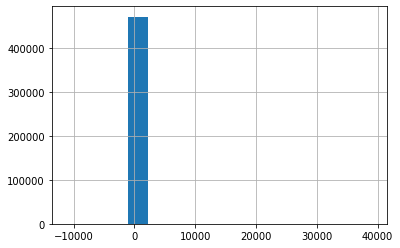

In [8]:
df['Sale'].hist(bins=15) # More or less log k + 1 if Gaussian distribution.
plt.show()

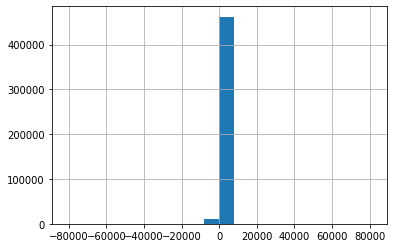

In [9]:
df['Qta'].hist(bins=20) # More or less log k + 1 if Gaussian distribution.
plt.show()

In [10]:
print("Distinct Values in CustomerCountry: \t", df.CustomerCountry.unique())

Distinct Values in CustomerCountry: 	 ['United Kingdom' 'France' 'Australia' 'Netherlands' 'Germany' 'Norway'
 'EIRE' 'Switzerland' 'Spain' 'Poland' 'Portugal' 'Italy' 'Belgium'
 'Lithuania' 'Japan' 'Iceland' 'Channel Islands' 'Denmark' 'Cyprus'
 'Sweden' 'Austria' 'Israel' 'Finland' 'Bahrain' 'Greece' 'Hong Kong'
 'Singapore' 'Lebanon' 'United Arab Emirates' 'Saudi Arabia'
 'Czech Republic' 'Canada' 'Unspecified' 'Brazil' 'USA'
 'European Community' 'Malta' 'RSA']


In [11]:
df['CustomerCountry'].value_counts()

United Kingdom          426261
Germany                   9495
France                    8525
EIRE                      7824
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               1932
Portugal                  1495
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Unspecified                340
USA                        291
Israel                     269
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Hong Kong                  138
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58
Lebanon 

In [12]:
df['CustomerID'].value_counts() # Good for understanding the frequency of purchasing of each customer.

17841.0    7983
14911.0    5903
14096.0    5128
12748.0    4642
14606.0    2782
           ... 
12943.0       1
13135.0       1
18068.0       1
17347.0       1
16093.0       1
Name: CustomerID, Length: 4372, dtype: int64

In [13]:
df['ProdDescr'].value_counts() # Good for understanding the most bought products.

WHITE HANGING HEART T-LIGHT HOLDER     2212
REGENCY CAKESTAND 3 TIER               2042
JUMBO BAG RED RETROSPOT                1917
PARTY BUNTING                          1569
LUNCH BAG RED RETROSPOT                1491
                                       ... 
incorrectly credited C550456 see 47       1
EASTER CRAFT IVY WREATH WITH CHICK        1
PURPLE ANEMONE ARTIFICIAL FLOWER          1
SET 10 CARDS CHRISTMAS HOLLY  17259       1
Not rcvd in 10/11/2010 delivery           1
Name: ProdDescr, Length: 4097, dtype: int64

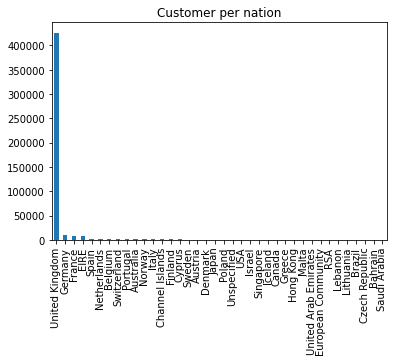

In [14]:
df['CustomerCountry'].value_counts().plot(kind='bar',
                                          title='Customer per nation')
plt.show()

In [15]:
df.corr() # Method: {‘pearson’, ‘kendall’, ‘spearman’}

,Sale,CustomerID,Qta
Sale,1.000000,-0.00456,-0.001247
CustomerID,-0.004560,1.00000,-0.003600
Qta,-0.001247,-0.00360,1.000000
